# Basal Ganglia on SpiNNaker and SpineML

This is a SpineML reproduction of Basab's SpiNNaker implementation of a GPR-like Basal Ganglia model. This notebook pertains to the single channel model only; there will be another notebook for the three channel model.

## Simple analysis from rate

This is very simple spike counting code, useful for constant input, steady state network analysis.

In [1]:
import numpy as np
def firing_rate (logdir1, spikelogfile, numneurons, simlength_ms, offset_ms=0):
    # Read first lot of data
    logpath = logdir1 + spikelogfile
    spikelist = np.genfromtxt (logpath, delimiter=',')
    
    if spikelist.size == 0:
        print ('Total rate in {0} neurons in {1}: 0 (empty log file)'.format(numneurons, spikelogfile))
        return 0, 0
    #print ('spikelist.shape: {0}'.format(spikelist.shape))
    # Number of rate total / number of neurons / time
    if spikelist.shape[0] == 2:
        trate = 1
    else:
        trate = len(spikelist[:,0])
        #print ('trate is {0}'.format(trate))
        sli = np.where(spikelist[:,0]>offset_ms)
        #print (spikelist[sli,0])
        trate = len(spikelist[sli,0].T)
        #print ('trate is {0}'.format(trate))

    print ('Total rate in {0} neurons in {1}: {2}'.format(numneurons, spikelogfile, trate))
    
    spnps = float(trate) / float(numneurons) / float(float(simlength_ms)/1000.0)
    print ('Mean spike rate: {0}'.format(spnps))
    
    return trate, spnps
    
    # I'd like to implement a moving bin to get a better estimate of the stats on the spike rate.
    # Shouldn't be too hard, except that as the spike rate is so low in some populations, I'd probably need
    # to run the model for much longer, so perhaps there's no great advantage over just running the model ten times.
    

## Analysis of bgbsb1_impt model
This model is designed to operate most closely like SpiNNaker. It achieves this by collecting impulses together and applying a limit on the size of the "weight" (SpiNNaker language - standing for conductivity in this model). This model is more complex than the simpler, SpineML-standard-style bgbsb1 model, as it has to have several additional populations to collect and sum impulses than the normal network, along with all the attendant additional connections.

In [ ]:
# Firing rates in all populations, steady state experiment 0
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e0/log/','D1_MSN_spike_log.csv', 1255, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e0/log/','D2_MSN_spike_log.csv', 1255, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e0/log/','FSI_spike_log.csv', 84, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e0/log/','STN_spike_log.csv', 14, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e0/log/','GPe_spike_log.csv', 46, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e0/log/','SNr_spike_log.csv', 27, 6000)

In [ ]:
# D1 with Poisson ONLY. Experiment 1
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e1/log/','D1_MSN_spike_log.csv', 1255, 2000)

In [37]:
# D1 with Poisson AND recurrent D1->D1 inhibition. Experiment 2
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e2/log/','D1_MSN_spike_log.csv', 1255, 2000)

Total spikes in 1255 neurons in D1_MSN_spike_log.csv: 1217
Mean spike rate: 0.484860557769


## Analysis of bgbsb1 model
The more typical SpineML-style model, which passes events rather than impulses.

In [24]:
# Firing rates in all populations, steady state experiment 0
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','D1_MSN_spike_log.csv', 1255, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','D2_MSN_spike_log.csv', 1255, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','FSI_spike_log.csv', 84, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','STN_spike_log.csv', 14, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','GPe_spike_log.csv', 46, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','SNr_spike_log.csv', 27, 6000)

spikelist.shape: (4258, 2)
Total spikes in 1255 neurons in D1_MSN_spike_log.csv: 4258
Mean spike rate: 0.565471447543
spikelist.shape: (2, 2)
Total spikes in 1255 neurons in D2_MSN_spike_log.csv: 1
Mean spike rate: 0.000132802124834
spikelist.shape: (5, 2)
Total spikes in 84 neurons in FSI_spike_log.csv: 5
Mean spike rate: 0.00992063492063
spikelist.shape: (1252, 2)
Total spikes in 14 neurons in STN_spike_log.csv: 1252
Mean spike rate: 14.9047619048
spikelist.shape: (8275, 2)
Total spikes in 46 neurons in GPe_spike_log.csv: 8275
Mean spike rate: 29.981884058
spikelist.shape: (3537, 2)
Total spikes in 27 neurons in SNr_spike_log.csv: 3537
Mean spike rate: 21.8333333333


In [43]:
# D1 with Poisson ONLY. Experiment 1
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e1/log/','D1_MSN_spike_log.csv', 1255, 6000)

Total spikes in 1255 neurons in D1_MSN_spike_log.csv: 1467
Mean spike rate: 0.194820717131


In [44]:
# D1 with Poisson AND recurrent D1->D1 inhibition. Experiment 2
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e2/log/','D1_MSN_spike_log.csv', 1255, 2000)

Total spikes in 1255 neurons in D1_MSN_spike_log.csv: 1217
Mean spike rate: 0.484860557769


## Batch running a model
Define code to run the model multiple times, collecting the firing rates each time and storing this to csv files.

Note that at present, the analysis of these results is via an R script (I would prefer to get this kind of bootstrap into python though, which would be neater).

In [2]:
def runsim (spineml2brahmsdir, modelbasedir, modeldir, expt=0):

    modelpath = modelbasedir + modeldir
    spineml2brahmsdir ='/home/seb/src/SpineML_2_BRAHMS'
    spinemltmp = spineml2brahmsdir+'/temp/'+ modeldir
    
    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahmsdir+' && ' +\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m ' + modelpath + ' -e' +\
                 `expt` + ' -g -o' + spinemltmp + '; popd"'

    #print spinemlcmd
    os.system(spinemlcmd)


In [7]:
def makeexpt (seed1, seed2):
    exstr = '<?xml version="1.0" encoding="UTF-8"?><SpineML xmlns:UL="http://www.shef.ac.uk/SpineMLNetworkLayer" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="http://www.shef.ac.uk/SpineMLExperimentLayer" xsi:schemaLocation="http://www.shef.ac.uk/SpineMLNetworkLayer SpineMLNetworkLayer.xsd http://www.shef.ac.uk/SpineMLExperimentLayer SpineMLExperimentLayer.xsd"><Experiment name="Steady state minlog" description="Run model with just the background input; no selected channel. Just spike logging."><Model network_layer_url="model.xml"/><Simulation duration="6" preferred_simulator="BRAHMS"><EulerIntegration dt="0.1"/></Simulation><TimeVaryingInput target="Background" port="spike" name="BG Poisson Spikes" rate_based_input="poisson" rate_seed="{0}"><TimePointValue time="0" value="0"/><TimePointValue time="700" value="3"/><TimePointValue time="5900" value="0"/></TimeVaryingInput><TimeVaryingInput target="BackgroundSTN" port="spike" name="BG STN" rate_based_input="poisson" rate_seed="{1}"><TimePointValue time="0" value="0"/><TimePointValue time="700" value="3"/><TimePointValue time="5900" value="0"/></TimeVaryingInput><LogOutput name="SNr spikes" target="SNr" port="spike" start_time="0" end_time="6.32404e-322"/><LogOutput name="GPe spikes" target="GPe" port="spike" start_time="0" end_time="6.32404e-322"/><LogOutput name="FSI spike" target="FSI" port="spike" start_time="0" end_time="6.32404e-322"/><LogOutput name="D1 spike" target="D1 MSN" port="spike" start_time="0" end_time="6.32404e-322"/><LogOutput name="D2 spike" target="D2 MSN" port="spike" start_time="0" end_time="6.32404e-322"/><LogOutput name="STN spikes" target="STN" port="spike" start_time="0" end_time="6.32404e-322"/></Experiment></SpineML>\n'.format(seed1,seed2)
    return exstr

In [10]:
modelbasedir = '/home/seb/models/GPR-BSB/'

# Choose bgbsb1 bgbsb1_impt bgbsb1_fixcon or bgbsb1_impt_fixcon:
modeldir = 'bgbsb1_impt_fixcon'
expt = 3
# Choose whether Poisson spike train seeds should be a predictable series:
predictable_seeds = 1

spineml2brahmsdir ='/home/seb/src/SpineML_2_BRAHMS'
spinemltmp = spineml2brahmsdir+'/temp/'+ modeldir

d1spikes = np.array([])
d2spikes = np.array([])
fsispikes = np.array([])
stnspikes = np.array([])
gpespikes = np.array([])
snrspikes = np.array([])

d1rate = np.array([])
d2rate = np.array([])
fsirate = np.array([])
stnrate = np.array([])
gperate = np.array([])
snrrate = np.array([])


if predictable_seeds:
    import subprocess
    epath = modelbasedir+modeldir+'/experiment{0}.xml'.format(expt)
    d1seed=153
    stnseed=154
    d1seeds = np.array([])
    stnseeds = np.array([])

for c in range(0,15):

    if predictable_seeds:
        # Set the same Poisson seed in each model. Assum both start with D1 seed 123 and STN seed 124
        print ('Run model for seeds {0} (D1) and {1} (STN)'.format(d1seed,stnseed))
        exstr = makeexpt(d1seed,stnseed)
        with open(epath, 'w') as f:
            f.write(exstr)
            f.close()

        d1seeds = np.append(d1seeds, d1seed)
        stnseeds = np.append(stnseeds, stnseed)
        d1seed = d1seed + 2
        stnseed = stnseed + 2
    
    runsim(spineml2brahmsdir, modelbasedir, modeldir, expt)

    spikes, rate = firing_rate(spinemltmp+'/log/','D1_MSN_spike_log.csv', 1255, 6000)
    d1spikes = np.append(d1spikes, spikes)
    d1rate = np.append(d1rate, rate)
    
    spikes, rate = firing_rate(spinemltmp+'/log/','D2_MSN_spike_log.csv', 1255, 6000)
    d2spikes = np.append(d2spikes, spikes)
    d2rate = np.append(d2rate, rate)

    spikes, rate = firing_rate(spinemltmp+'/log/','FSI_spike_log.csv', 84, 6000)
    fsispikes = np.append(fsispikes, spikes)
    fsirate = np.append(fsirate, rate)

    spikes, rate = firing_rate(spinemltmp+'/log/','STN_spike_log.csv', 14, 6000)
    stnspikes = np.append(stnspikes, spikes)
    stnrate = np.append(stnrate, rate)
    
    spikes, rate = firing_rate(spinemltmp+'/log/','GPe_spike_log.csv', 46, 6000)
    gpespikes = np.append(gpespikes, spikes)
    gperate = np.append(gperate, rate)
    
    spikes, rate = firing_rate(spinemltmp+'/log/','SNr_spike_log.csv', 27, 6000)
    snrspikes = np.append(snrspikes, spikes)
    snrrate = np.append(snrrate, rate)

# Save the spikes and rates
np.savetxt(modelbasedir+'/labbook/'+'d1spikes.csv', d1spikes, fmt='%d', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'d2spikes.csv', d2spikes, fmt='%d', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'fsispikes.csv', fsispikes, fmt='%d', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'stnspikes.csv', stnspikes, fmt='%d', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'gpespikes.csv', gpespikes, fmt='%d', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'snrspikes.csv', snrspikes, fmt='%d', delimiter=',', newline='\n')

np.savetxt(modelbasedir+'/labbook/'+'d1rates.csv', d1rate, fmt='%.8f', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'d2rates.csv', d2rate, fmt='%.8f', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'fsirates.csv', fsirate, fmt='%.8f', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'stnrates.csv', stnrate, fmt='%.8f', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'gperates.csv', gperate, fmt='%.8f', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'snrrates.csv', snrrate, fmt='%.8f', delimiter=',', newline='\n')

if predictable_seeds:
    np.savetxt(modelbasedir+'/labbook/'+'d1seeds.csv', d1seeds, fmt='%d', delimiter=',', newline='\n')
    np.savetxt(modelbasedir+'/labbook/'+'stnseeds.csv', stnseeds, fmt='%d', delimiter=',', newline='\n')

    # Reset seeds in expt:
    exstr = makeexpt(0,0)
    with open(epath, 'w') as f:
        f.write(exstr)
        f.close()


Run model for seeds 153 (D1) and 154 (STN)
Total rate in 1255 neurons in D1_MSN_spike_log.csv: 2966
Mean spike rate: 0.393891102258
Total rate in 1255 neurons in D2_MSN_spike_log.csv: 0 (empty log file)
Total rate in 84 neurons in FSI_spike_log.csv: 0 (empty log file)
Total rate in 14 neurons in STN_spike_log.csv: 1175
Mean spike rate: 13.9880952381
Total rate in 46 neurons in GPe_spike_log.csv: 8540
Mean spike rate: 30.9420289855
Total rate in 27 neurons in SNr_spike_log.csv: 3701
Mean spike rate: 22.8456790123
Run model for seeds 155 (D1) and 156 (STN)
Total rate in 1255 neurons in D1_MSN_spike_log.csv: 3236
Mean spike rate: 0.429747675963
Total rate in 1255 neurons in D2_MSN_spike_log.csv: 0 (empty log file)
Total rate in 84 neurons in FSI_spike_log.csv: 1
Mean spike rate: 0.00198412698413
Total rate in 14 neurons in STN_spike_log.csv: 1157
Mean spike rate: 13.7738095238
Total rate in 46 neurons in GPe_spike_log.csv: 8522
Mean spike rate: 30.8768115942
Total rate in 27 neurons in SN

## Firing rate histogram

This is for Fig 6 in the paper, to match the histogram which Basab produced.


In [10]:
# Visualisation of mean firing rates from bg1 simulation, with and without sigmoid.
import numpy as np

# Graph the data. Sub-called by vis_data
def graph_data (bin_edges, fr, logfile):
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))
    #plt.clf;

    plt.plot (bin_edges[0:-1],fr, '--', color='r', marker='o', label='Channel 1', linewidth=3)

    plt.legend(loc='best',fontsize=14)

    plt.xlabel('t (ms)',fontsize=24);
    
    from matplotlib import rc
    plt.ylabel('mean neuronal firing rate (s$^{-1}$)',fontsize=24);
    plt.tick_params(axis='x', labelsize=24, pad=10)
    plt.tick_params(axis='y', labelsize=24, pad=10)
    
    plt.title(logfile)

    graphdir = '/home/seb/models/GPR-BSB/labbook/'

    filename = logfile.replace(' ','_')
    plt.savefig('{0}{1}.svg'.format(graphdir, filename))
    
    plt.show()
    
# Read & precompute the data. Sub-called by vis_data and compute_decision
def compute_data (logdir1, logfile, numneurons, simlength_ms):
    # Read first lot of data
    logpath = logdir1 + logfile
    spikelist = np.genfromtxt (logpath, delimiter=',')
    
    numbins = 100

    ch1fr, bin_edges1 = np.histogram (spikelist[:,0], numbins)

    # There are 20 neurons per channel in this model, 60 total
    num_channels_used = 1
    neuronsPerInvestigation = numneurons * num_channels_used
    
    # Scale the firing rates
    bintime = simlength_ms / numbins;
    fr  = (ch1fr) * 1000 / (bintime * numneurons)

    return bin_edges1, fr

# Visualise the given logfile (the log of a single population) 
def vis_data (logdir1, logfile, numneurons, simlength_ms):
    bin_edges, fr = compute_data (logdir1, logfile, numneurons, simlength_ms)
    graph_data (bin_edges, fr, logfile)
    return bin_edges, fr

## end visualisation functions

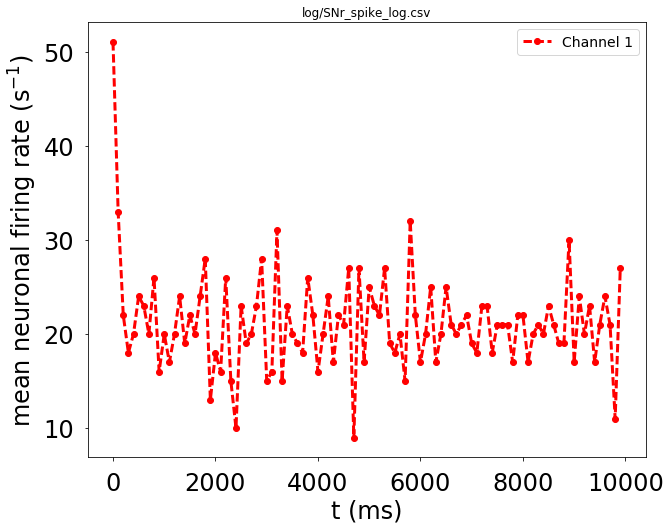

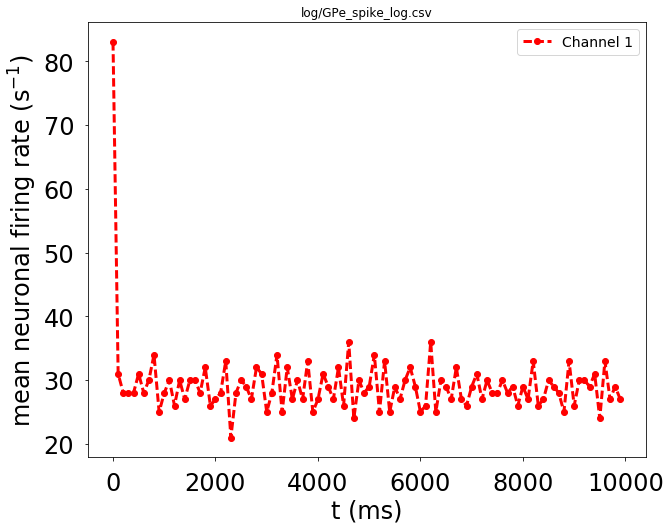

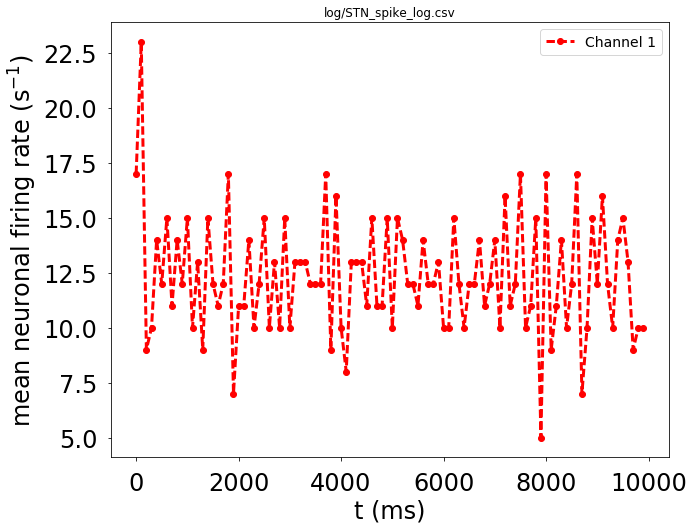

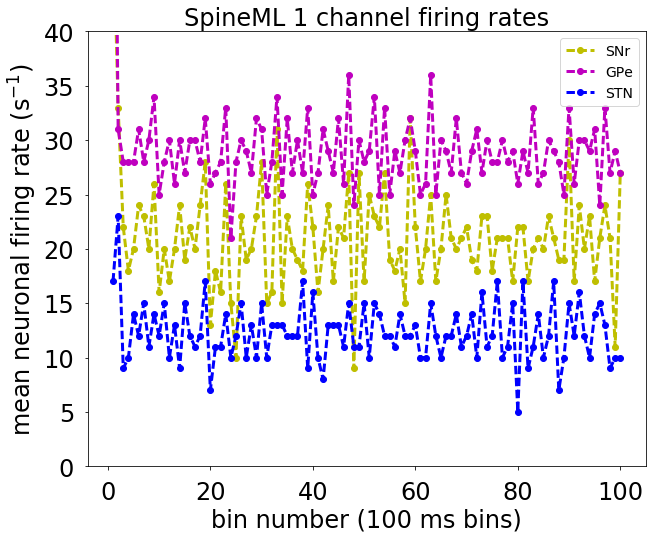

In [24]:
modelbasedir = '/home/seb/models/GPR-BSB/'
modeldir = 'bgbsb1'
expt = 6 # steady state 10s
spineml2brahmsdir ='/home/seb/src/SpineML_2_BRAHMS'
spinemltmp = spineml2brahmsdir+'/temp/'+ modeldir+'/'

recompute = 0
if recompute > 0:
    runsim(spineml2brahmsdir, modelbasedir, modeldir, expt)

binedges1, snr_rates = vis_data (spinemltmp, 'log/SNr_spike_log.csv', 27, 10000) 
binedges2, gpe_rates = vis_data (spinemltmp, 'log/GPe_spike_log.csv', 46, 10000) 
binedges3, stn_rates = vis_data (spinemltmp, 'log/STN_spike_log.csv', 14, 10000) 

binnums = np.linspace(1,100,100)

# Make a combined plot.
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))

#plt.plot (binedges1[0:-1],snr_rates, '--', color='y', marker='o', label='SNr', linewidth=3)
#plt.plot (binedges2[0:-1],gpe_rates, '--', color='m', marker='o', label='GPe', linewidth=3)
#plt.plot (binedges3[0:-1],stn_rates, '--', color='b', marker='o', label='STN', linewidth=3)

plt.plot (binnums, snr_rates, '--', color='y', marker='o', label='SNr', linewidth=3)
plt.plot (binnums, gpe_rates, '--', color='m', marker='o', label='GPe', linewidth=3)
plt.plot (binnums, stn_rates, '--', color='b', marker='o', label='STN', linewidth=3)

plt.legend(loc='best',fontsize=14)

plt.xlabel('bin number (100 ms bins)',fontsize=24);

from matplotlib import rc
plt.ylabel('mean neuronal firing rate (s$^{-1}$)',fontsize=24);
plt.tick_params(axis='x', labelsize=24, pad=10)
plt.tick_params(axis='y', labelsize=24, pad=10)

plt.ylim([0,40])

plt.title('SpineML 1 channel firing rates', fontsize=24)

graphdir = '/home/seb/models/GPR-BSB/labbook/results/bgbsb1/'

filename = 'bgbsb1_rates'
plt.savefig('{0}{1}.svg'.format(graphdir, filename))

plt.show()

# Save data to csv:
onech_rates = binedges1[0:-1] # to do vs time
onech_rates= np.vstack((onech_rates,binnums,snr_rates,gpe_rates,stn_rates))
np.savetxt(graphdir+'bgbsb1_rates.csv', onech_rates.T, fmt='%d', delimiter=',', header='t(ms),binnum,snr,gpe,stn', newline='\n')